# RADA
### Baoxiang Pan
### 2021.10.27

## **1. Data** 
### 1.1 Data download
#### 1.1.1 Climate simulation data

Go to https://esgf-node.llnl.gov/search/cmip6/. 
Create an account if needed.

Here we consider the 3h high resolution simulation from MPI-ESM1-2-HR. We use the AMIP experimental data for model training, validation, test. Besides, we also test the mode extrapolation capability for future scenario. The ssp 126, 245, 370, 585 scenarios are considered. Therefore, select the following filtering conditions:

| Filter      | Description |
| ----------- | ----------- |
| Model       | MPI-ESM1-2-HR       |
| Experiment  | AMIP, ssp126, ssp245, ssp370, ssp585|
| Variable    | pr, prw, psl|
| Frequency   | 3 hour   |

Fetch the wget script, run with <code>bash *sh</code> to store the data in your working directory.

#### 1.1.2 Observation


Here is the MMA code for creating wget script to download the MSWEP 3h, 0.1° precipitation data (Beck et al. 2019 BAMS).

In [1]:
obserP=Map[DateString[#,{"wget -nc http://hydrology.princeton.edu/data/hylkeb/MSWEP_V220/global_3hourly_010deg/","Year","Month",".nc"}]&,
DateRange[{1979,1,1},{2017,12,1},"Month"]];
Export["MSWEP_P_Wget.sh",obserP,"Table"];

Run <code>bash MSWEP_P_Wget.sh</code> to start downloading the MSWEP precipitation data.

#### 1.1.3 Reanalysis (https://www.ncei.noaa.gov/data/climate-forecast-system/access/)

Here is the MMA code for creating wget script to downlaod the CFSR hourly, 0.5° reanalysis data (including prw and psl here, Saha, S., et al. 2011).

In [7]:
(* vars={"z1000","z850","z500","z200","q925","q850","q500","prmsl","pwat"}; *)
vars={"prmsl","pwat"}; 
dates=DateRange[{1979,1,1},{2011,3,1},"Month"];
script=Flatten[Table[Block[{date=DateString[dates[[i]],{"Year","Month"}]},
"wget -nc https://www.ncei.noaa.gov/data/climate-forecast-system/access/reanalysis/time-series/"<>date<>"/"<>vars[[j]]<>".gdas."<>date<>".grb2"],{i,Length[dates]},{j,Length[vars]}]];
Export["reanalysis_1979-2011.sh",script,"Table"]

dates=DateRange[{2011,4,1},{2021,10,1},"Month"];
script=Flatten[Table[Table[DateString[dates[[i]],
{"wget -nc https://www.ncei.noaa.gov/data/climate-forecast-system/access/operational-analysis/time-series/","Year","/","Year","Month","/",vars[[j]],".gdas.","Year","Month",".grib2"}],{j,Length[vars]}],{i,Length[dates]}]];
Export["reanalysis_2011-2021.sh",script,"Table"]

reanalysis_1979-2011.sh
reanalysis_2011-2021.sh

Run <code>bash reanalysis_1979-2011.sh</code> and <code>bash reanalysis_2011-2021.sh</code> to start downloading the CFS reanalysis data.

### 1.2 Data preprocessing

This case study focus on the Contiguous United States (CONUS, 22°N-51°N, 65°W-127°W). As an illustration, run the following code to create the geomap of the study region.

GeoGraphics[-Graphics-, GeoBackground -> Automatic, 
 
                                    527
>   GeoCenter -> GeoPosition[{36.5, ---}], GeoGridLines -> None, 
                                     2
 
>   GeoGridLinesStyle -> GrayLevel[0.4, 0.3], 
 
>   GeoGridRange -> {{233., 294.}, {22.5614, 59.4801}}, GeoGridRangePadding -> None, 
 
>   GeoModel -> ITRF00, GeoProjection -> Mercator, 
 
>   GeoRange -> {{22., 51.}, {233., 294.}}, GeoRangePadding -> Full, 
 
>   GeoResolution -> Automatic, GeoServer -> {Automatic}, GeoZoomLevel -> 3, 
 
>   MetaInformation -> 
 
>    {GeoModel -> ITRF00, LonLatBox -> {{233., 294.}, {22., 51.}}, 
 
>     PlotRange -> {{232.91, 294.082}, {22.5, 59.5898}}, Projection -> Mercator, 
 
>     Software -> Created with the Wolfram Language: www.wolfram.com, 
 
>     TileSources -> 
 
>      Wolfram Knowledgebase with data from © OpenStreetMap contributors:\
 
>       http://www.openstreetmap.org/copyright}]
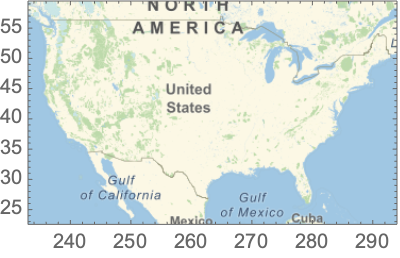

In [2]:
name="CONUS";
range={{22., 51.}, {233, 294}};
GeoGraphics[Entity["Country","UnitedStates"],GeoProjection->"Mercator",Frame->True,GeoRange->range,ImageSize->200]

#### 1.2.1 Climate simulation data

Check the var names in the nc file, cut the data to fit the study region.

In [5]:
classes={"*MPI-ESM1-2-HR*amip_*r2i1p1f1*","*MPI-ESM1-2-HR*amip_*r3i1p1f1*",
         "*MPI-ESM1-2-HR*ssp126_*r2i1p1f1*","*MPI-ESM1-2-HR*ssp245_*r2i1p1f1*",
         "*MPI-ESM1-2-HR*ssp370_*r2i1p1f1*","*MPI-ESM1-2-HR*ssp585_*r2i1p1f1*"};

psl   /time   /time_bnds   /lat   /lat_bnds   /lon   /bnds   /lon_bnds   /psl
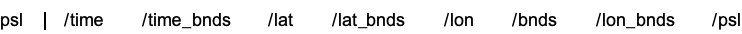

In [14]:
class=classes[[-1]];         
SetDirectory["/Volumes/lambda/MPI_ESM"];
vars={"pr","prw","psl"};
vars={"pr","prw"};
vars={"psl"};
files=Table[FileNames[vars[[i]]<>"_"<>class],{i,Length[vars]}];
variables=Map[Import[#[[1]]]&,files];
Style[TableForm[variables,TableHeadings->{vars,None}],{FontFamily->"Arial",9}]

In [22]:
Dimensions[files]

{1, 18}

lat   lon
Dim   192   384
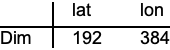

In [23]:
lats=Map[Import[#[[1]],{"Datasets","/lat"}]&,files];
lons=Map[Import[#[[1]],{"Datasets","/lon"}]&,files];
Mlat=Block[{tempt=DeleteDuplicates[lats]},If[Length[tempt]==1,tempt[[1]]]];
Mlon=Block[{tempt=DeleteDuplicates[lons]},If[Length[tempt]==1,tempt[[1]]]];
Style[TableForm[{{Length[Mlat],Length[Mlon]}},TableHeadings->{{Dim},{"lat","lon"}}],{FontFamily->"Arial",9}]

Range   Model     Position
Min lat   22.     21.9739   120

Max lat   51.     50.9608   151

Min lon   233     233.438   250

Max lon   294     294.375   315
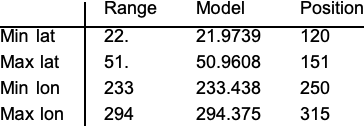

In [28]:
b=Nearest[Mlat,range[[1,1]]][[1]];
t=Nearest[Mlat,range[[1,2]]][[1]];
l=Nearest[Mlon,range[[2,1]]][[1]];
r=Nearest[Mlon,range[[2,2]]][[1]];
position={{Position[Mlat,b][[1,1]],Position[Mlat,t][[1,1]]},{Position[Mlon,l][[1,1]],Position[Mlon,r][[1,1]]}};
Style[TableForm[{{range[[1,1]],b,position[[1,1]]},{range[[1,2]],t,position[[1,2]]},
                 {range[[2,1]],l,position[[2,1]]},{range[[2,2]],r,position[[2,2]]}},TableHeadings->{{"Min lat","Max lat","Min lon","Max lon"},
{"Range","Model","Position"}}],{FontFamily->"Arial",9}]

In [34]:
data=Table[Table[Block[{tempt},
    Print[{vars[[v]],files[[v,date]]}];
    tempt=Import[files[[v,date]],{"Datasets",variables[[v,-1]]}];
    tempt[[;;,position[[1,1]];;position[[1,2]],position[[2,1]];;position[[2,2]]]]],{date,Length[files[[v]]]}],{v,Length[vars]}];

{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_201501010130-201912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_202001010130-202412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_202501010130-202912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_203001010130-203412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_203501010130-203912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_204001010130-204412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_204501010130-204912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_205001010130-205412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_205501010130-205912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_206001010130-206412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_206501010130-206912312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_207001010130-207412312230.nc}
{psl, psl_E3hr_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn_207501010130-207

In [35]:
Table[Print[vars[[v]]];
Export[vars[[v]]<>"_"<>StringRiffle[DeleteCases[StringSplit[class,{"*","_"}],""],"_"]<>".mx",
 <|"data"->NumericArray[Flatten[data[[v]],1],"Real32"],
   "var"->vars[[v]],
   "date"->"1979.1.1-2014.12.31, 3h",
   "lat"->Mlat[[position[[1,1]];;position[[1,2]]]],
   "lon"->Mlon[[position[[2,1]];;position[[2,2]]]]|>],{v,Length[vars]}];

psl


### 1.3 Look into the data (crucial in data-driven modeling)

Check the **mean**, **variance**, **diurnal variability**, **extremes** of the precipitation observational data:

Check the **mean**, **variance**, **diurnal variability**, **extremes** of the precipitation simulation data:

Check the **mean**, **variance**, **diurnal variability**, **extremes** of the reanalysis circulation field data:

Check the **mean**, **variance**, **diurnal variability**, **extremes** of the climate simulation circulation field data: